This notebook compares sklearn models on the energy per atom prediction task. Dichalcogenides 4x4, 5x5 and 6x6 dataset is used.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from catboost import CatBoostRegressor, Pool
from screening.scripts.dataset import collect_features, collect_properties

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from bson import ObjectId

from sklearn.model_selection import train_test_split

In [2]:
database='dichalcogenides'

In [3]:
features = collect_features(database).set_index("_id")
target = collect_properties(database).set_index("_id")

In [4]:
property_ = 'energy_per_atom'

In [5]:
df = features.join(target[property_])
supervised = df[df[property_].notna()]
unsupervised = df[df[property_].isna()].drop([property_], axis = 1)
x = supervised.drop([property_], axis=1)
y = supervised[property_]

## Model training

In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold


In [7]:
gp = GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel(), alpha=100)
kr = KernelRidge(kernel='laplacian')
rf = RandomForestRegressor(n_estimators=100)
ridge = Ridge()
knn = KNeighborsRegressor(10, weights='distance')
svr = SVR(kernel='rbf')
cb = CatBoostRegressor(iterations=2000, loss_function='MAE',
                          verbose=False, random_seed=0)

In [8]:
def train(model, x, y, do_pca):
    if do_pca:
        pca = PCA(10)
        x_processed = pca.fit_transform(x)
    else:
        x_processed = x.values
    
    kf = KFold(n_splits=4, shuffle=True)
    preds = np.zeros(len(y))
    scores = []

    for train_index, test_index in kf.split(x):
        x_train, x_test, y_train, y_test =\
            x_processed[train_index], x_processed[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train)
        preds[test_index] = model.predict(x_test)
    return preds

In [10]:
gp_preds = train(gp, x, y, True)
kr_preds = train(kr, x, y, False)
rf_preds = train(rf, x, y, False)
ridge_preds = train(ridge, x, y, False)
knn_preds = train(knn, x, y, True)
svr_preds = train(svr, x, y, True)
cb_preds = train(cb, x, y, False)

In [11]:
gp_score = mean_absolute_error(gp_preds, y)
kr_score = mean_absolute_error(kr_preds, y)
rf_score = mean_absolute_error(rf_preds, y)
ridge_score = mean_absolute_error(ridge_preds, y)
knn_score = mean_absolute_error(knn_preds, y)
svr_score = mean_absolute_error(svr_preds, y)
cb_score = mean_absolute_error(cb_preds, y)

In [12]:
pd.DataFrame([["Gaussian Process", gp_score],
             ["Kernel Ridge", kr_score],
             ["Random Forest", rf_score],
             ["Ridge", ridge_score],
             ["KNN", knn_score],
             ["SVR", svr_score],
             ["CatBoost", cb_score]],
            columns = ["model", "MAE"])

,model,MAE
0,Gaussian Process,0.026752
1,Kernel Ridge,0.053457
2,Random Forest,0.000800
3,Ridge,0.004926
4,KNN,0.010161
5,SVR,0.107151
6,CatBoost,0.000991


Text(0.5, 1.0, 'Dichalcogenides predicted vs true energy')

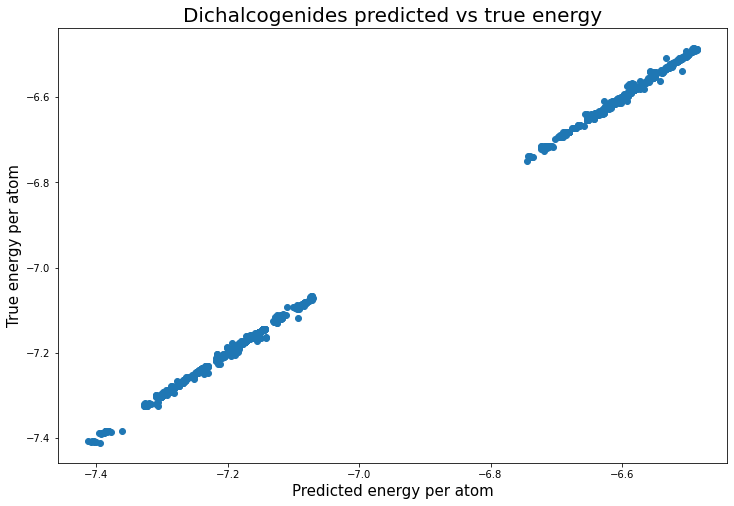

In [14]:
plt.subplots(figsize=(12, 8))
plt.scatter(cb_preds, y)
plt.xlabel("Predicted energy per atom", fontsize=15)
plt.ylabel('True energy per atom', fontsize=15)
plt.title("Dichalcogenides predicted vs true energy", fontsize=20)